# Inits

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

# Organizing, scaling data for ML methods
All columns not relating to predicting score (INCLUDING non-normalized distance from TSS) are dropped in the creation of the training and test sets

## Reading in data

In [259]:
read_df = pd.read_csv("structured_set.csv", index_col = 0)
read_df["same_strand"] = (read_df["strand targeted"] == read_df["strand"]).astype(int)

# filter out all columns that only have a singular value in them
df = read_df.loc[:, read_df.nunique() > 1]

X = df.drop(columns = ["score", 
                       "gene", 
                       "chromosome",
                       "PAM_coord",
                       "strand",
                       "strand targeted", 
                       "sequence", 
                       "transcript", 
                       "TSS source",
                       "prim_TSS_5p",
                       "prim_TSS_3p",
                       "sec_TSS_5p",
                       "sec_TSS_3p",
                       "norm_prim_TSS_dist5p",
                       "norm_prim_TSS_dist3p",
                       "norm_sec_TSS_dist5p",
                       "norm_sec_TSS_dist3p",
                       "struct"])
y = df.loc[:, "score"]

## Preprocessing

In [334]:
stan = StandardScaler()
stan_cols = ["prim_TSS_dist5p", "prim_TSS_dist3p", "sec_TSS_dist5p", "sec_TSS_dist3p", "length", "GC_content", "GA_content", "CA_content", "frac_A", "frac_C", "frac_T", "frac_G"]

minmax = MinMaxScaler()
minmax_cols = ["longest_A", "longest_C", "longest_T", "longest_G", "mfe"]
minmax_cols.extend([(str(i) + "_MMs") for i in range(4)])
minmax_cols.extend([("num_MMs_pos" + str(i + 1)) for i in range(25)])

# minmax_cols.extend(stan_cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# applying scaling AFTER splitting - this is so the training and test set are scaled relative to their own set
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[stan_cols] = stan.fit_transform(X_train_scaled[stan_cols])
X_train_scaled[minmax_cols] = minmax.fit_transform(X_train_scaled[minmax_cols])
X_test_scaled[stan_cols] = stan.transform(X_test_scaled[stan_cols])
X_test_scaled[minmax_cols] = minmax.transform(X_test_scaled[minmax_cols])

# y_train_scaled = y_train.copy()
# y_test_scaled = y_test.copy()
# y_train_scaled = minmax.fit_transform(y_train_scaled.values.reshape([-1, 1]))
# y_test_scaled = minmax.fit_transform(y_test_scaled.values.reshape([-1, 1]))

In [261]:
imp_title = (["unimportant"] * 4) + ["length"] + (["unimportant"] * 9) + (["TSS_distance"] * 4) + (["unimportant"] * 4) + (["ACTG_composition"] * 4) + (["dimer_composition"] * 3) + \
    (["ACTG_pos"] * (4 * 25)) + (["dimer_pos"] * ((4 ** 2) * 24)) + (["OT"] * (4 + 25)) + ["unimportant"] + ["mfe"] + (["secondary_struct"] * 25 * 3) + (["longest_ACTG"] * 4) + ["strand"]
imp_series = pd.Series(imp_title)
mask = read_df.nunique() > 1
imp_series = imp_series[mask.values]
imp_title = imp_series[imp_series != "unimportant"]

# Support Vector Regression

## Fitting model

In [5]:
from sklearn.svm import SVR

# svr = SVR(kernel = "rbf")

# params = {
#     "C": Real(0.0001, 1000, prior = "log-uniform"),
#     "gamma": Real(1e-9, 0.1, prior = "log-uniform"),
# }

# grid_svr = BayesSearchCV(svr, params, scoring = "neg_mean_squared_error", n_iter = 50, cv = 5, n_points = 2, verbose = 1)
# grid_svr.fit(X_train_scaled, y_train)
# best_svr = grid_svr.best_estimator_
# with open("models/SVR.pk1", "wb") as file:
#     pickle.dump(grid_svr.best_estimator_, file)
    
with open("models/SVR.pk1", "rb") as file:
    best_svr = pickle.load(file)

## Comparing model fit with test set

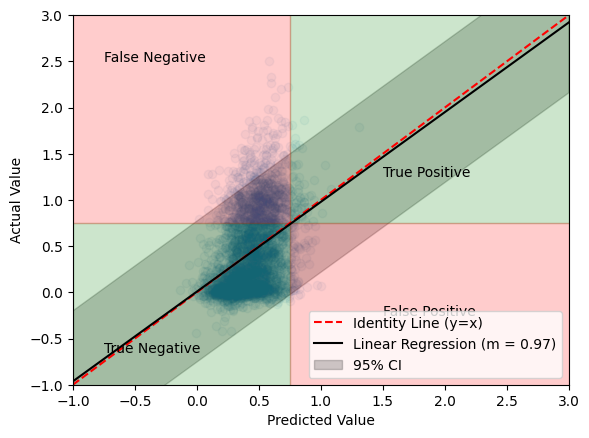

In [52]:
y_pred = best_svr.predict(X_test_scaled)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.05)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line (y=x)')
plt.plot(x, lin_reg.predict(x.reshape(-1, 1)), color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(1.5, 1.25, "True Positive")
plt.text(-0.75, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(-0.75, 2.5, "False Negative")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

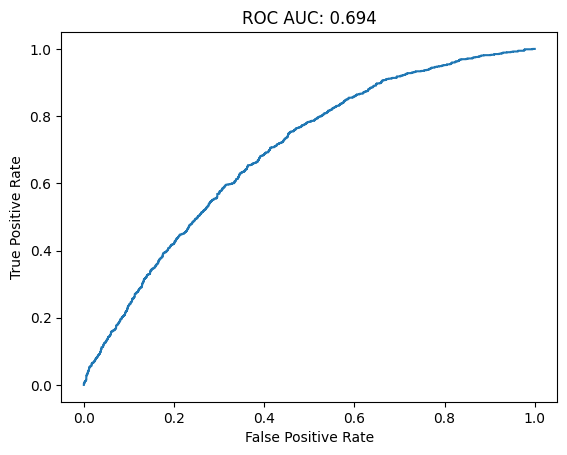

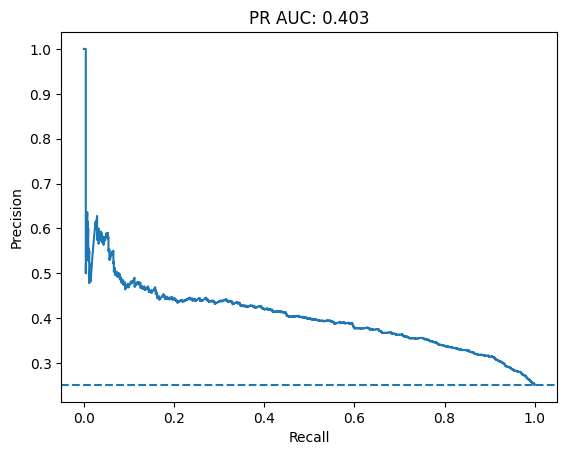

F1 score:  0.12927756653992395


In [7]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

# Random Forest Regression
Gilbert and his lab used elastic net linear regression - I tried this, but it just wasn't working. Random forest offers a more robust analysis and cares less about the scale of the features, but is more black box and harder to interpret.

## Fitting model

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

params = {
    "n_estimators": Integer(1, 500),
    "max_depth": Integer(1, 100),
    "min_samples_leaf": Real(0.0001, 0.9999, prior = "log-uniform")
}

grid_rf_reg = BayesSearchCV(rf_reg, params, scoring = "neg_mean_squared_error", n_iter = 30, n_jobs = -1, cv = 5, n_points = 5, verbose = 1)
_ = grid_rf_reg.fit(X_train_scaled, y_train)
best_rf_reg = grid_rf_reg.best_estimator_
joblib.dump(grid_rf_reg.best_estimator_, "models/RF.joblib", compress = ("lzma", 3))

# best_rf_reg = joblib.load("models/RF.joblib")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


['models/RF.joblib']

## Comparing model fit with test set

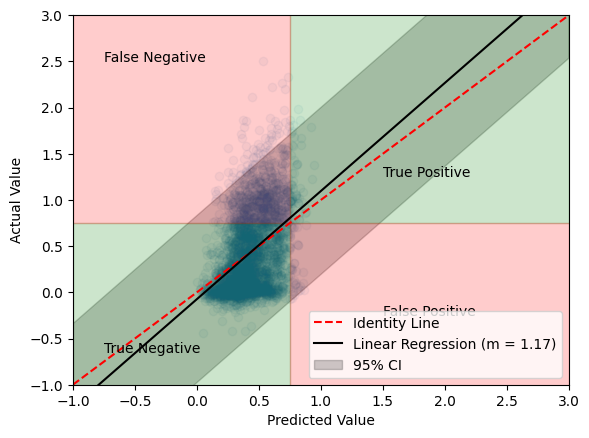

In [36]:
y_pred = best_rf_reg.predict(X_test_scaled)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.05)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line')
plt.plot(x, lin_reg.predict(x.reshape(-1, 1)), color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(1.5, 1.25, "True Positive")
plt.text(-0.75, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(-0.75, 2.5, "False Negative")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

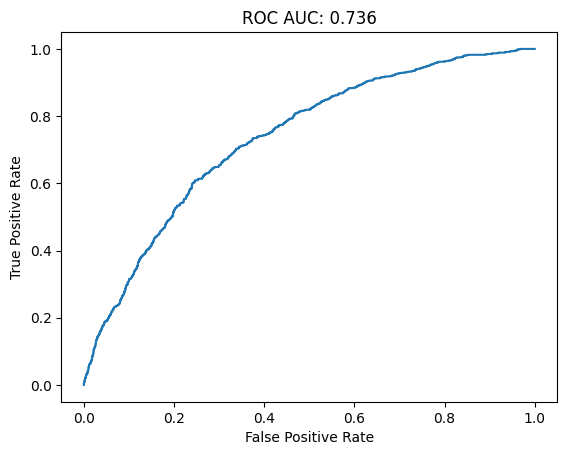

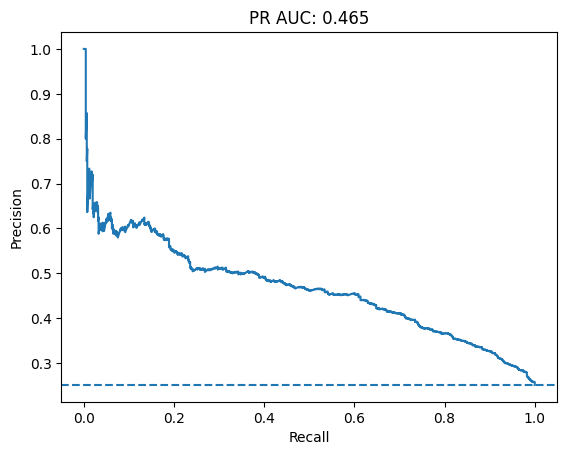

F1 score:  0.11648568608094768


In [13]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

## Feature importances

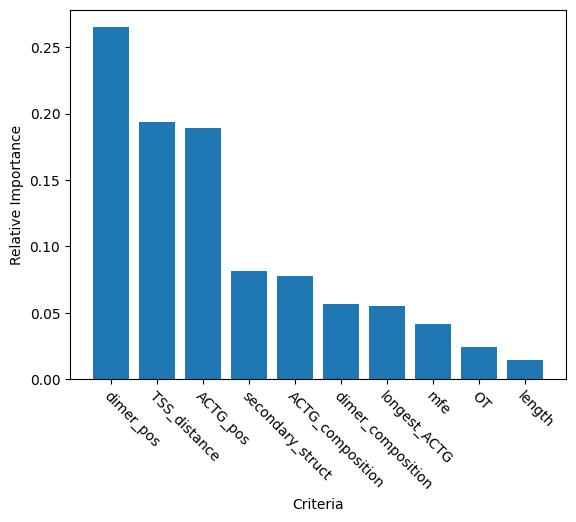

In [15]:
feature_imps = best_rf_reg.feature_importances_
sum_imps = feature_imps.sum()
imp_df = pd.DataFrame({
    "title": imp_title,
    "importance": feature_imps / sum_imps
})
grouped_imp_df = imp_df.groupby("title").sum().reset_index().sort_values(by = "importance", ascending = False)

plt.figure()
plt.bar(grouped_imp_df["title"], grouped_imp_df["importance"])
plt.xticks(rotation = -45, ha = "left", rotation_mode = "anchor")
plt.xlabel("Criteria")
plt.ylabel("Relative Importance")
plt.show()

# Light Gradient Boosting Machine Regression
Allegedly more robust than random forest regression.

## Fitting model

In [335]:
from lightgbm import LGBMRegressor

# lgbm_reg = LGBMRegressor(verbose = 0)

# params = {
#     "n_estimators": Integer(50, 500),
#     "learning_rate": Real(0.001, 0.3, prior = "log-uniform"),
#     "num_leaves": Integer(2, 100),
#     "reg_lambda": Real(0.001, 10, prior = "log-uniform"),
#     "reg_alpha": Real(0.001, 10, prior = "log-uniform"),
# }

# grid_lgbm_reg = BayesSearchCV(lgbm_reg, params, scoring = "r2", n_iter = 30, cv = 5, n_points = 2, verbose = 1)
# _ = grid_lgbm_reg.fit(X_train_scaled, y_train)
# best_lgbm_reg = grid_lgbm_reg.best_estimator_
# with open("models/LGBM.pk1", "wb") as file:
#     pickle.dump(best_lgbm_reg, file)
    
with open("models/LGBM.pk1", "rb") as file:
    best_lgbm_reg = pickle.load(file)

## Comparing model fit with test set

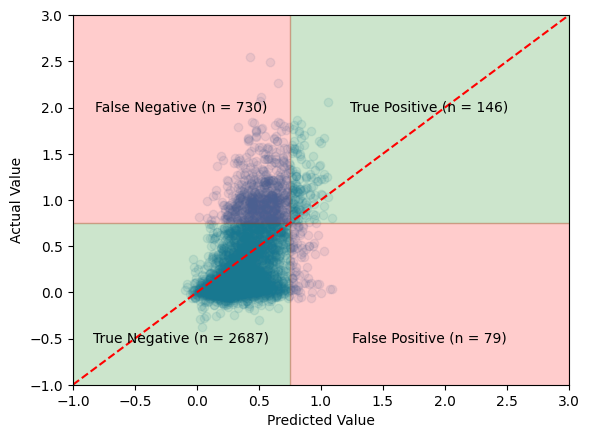

In [336]:
y_pred = best_lgbm_reg.predict(X_test_scaled)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
lr_residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(lr_residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

plot_df = pd.DataFrame({"x": y_pred, "y": y_test})

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line')
# plt.plot(x, y_pred_lr, color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
# plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(np.mean((xmax, threshold)), 
         2,
         f"True Positive (n = {plot_df[(plot_df['x'] > threshold) & (plot_df['y'] > threshold)].shape[0]})", 
         horizontalalignment = "center", 
         verticalalignment = "center")
plt.text(np.mean((xmin, threshold)), 
         -0.5, 
         f"True Negative (n = {plot_df[(plot_df['x'] < threshold) & (plot_df['y'] < threshold)].shape[0]})", 
         horizontalalignment = "center", 
         verticalalignment = "center")
plt.text(np.mean((xmax, threshold)), 
         -0.5,
         f"False Positive (n = {plot_df[(plot_df['x'] > threshold) & (plot_df['y'] < threshold)].shape[0]})",
         horizontalalignment = "center", 
         verticalalignment = "center")
plt.text(np.mean((xmin, threshold)), 
         2,
         f"False Negative (n = {plot_df[(plot_df['x'] < threshold) & (plot_df['y'] > threshold)].shape[0]})", 
         horizontalalignment = "center",
         verticalalignment = "center")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
# plt.legend()
plt.show()

## ROC curve (and other metrics)

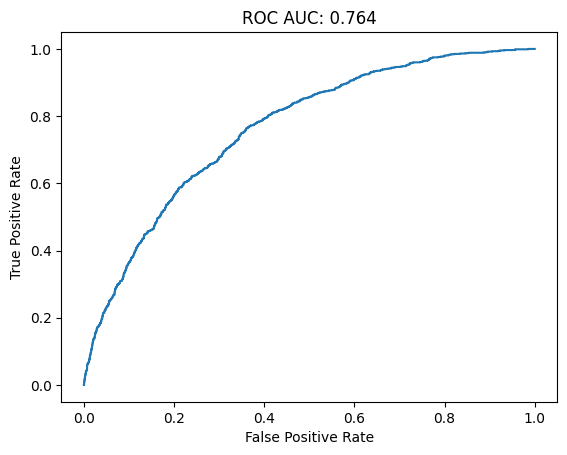

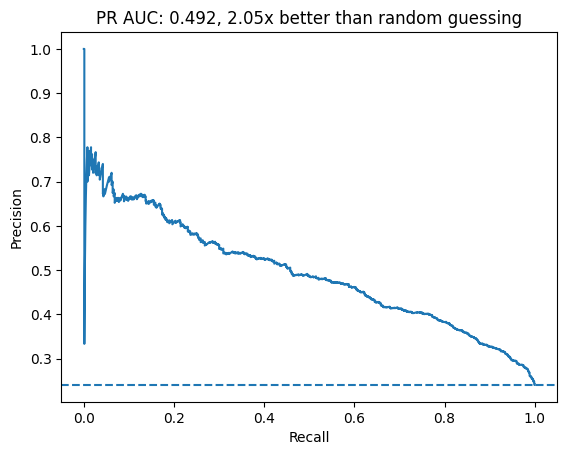

F1 score:  0.2652134423251589


In [10]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)) + ", " + str(round(roc_pr / prevalence, 2)) + "x better than random guessing")
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

## Feature importances

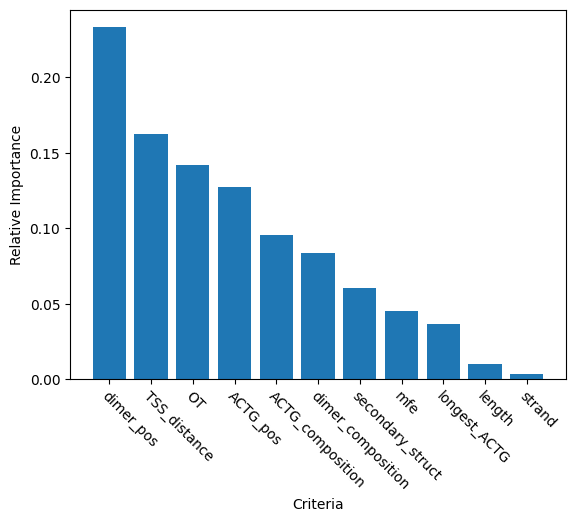

In [14]:
feature_imps = best_lgbm_reg.feature_importances_
sum_imps = feature_imps.sum()
imp_df = pd.DataFrame({
    "title": imp_title,
    "importance": feature_imps / sum_imps
})
grouped_imp_df = imp_df.groupby("title").sum().reset_index().sort_values(by = "importance", ascending = False)

plt.figure()
plt.bar(grouped_imp_df["title"], grouped_imp_df["importance"])
plt.xticks(rotation = -45, ha = "left", rotation_mode = "anchor")
plt.xlabel("Criteria")
plt.ylabel("Relative Importance")
plt.show()

# XGBoost Regression

## Fitting model

In [57]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(n_jobs = -1)

params = {
    "n_estimators": Integer(50, 500),
    "learning_rate": Real(0.001, 0.3, prior = "log-uniform"),
    "reg_lambda": Real(0.001, 100, prior = "log-uniform"),
    "reg_alpha": Real(0.001, 100, prior = "log-uniform"),
}

grid_xgb_reg = BayesSearchCV(xgb_reg, params, scoring = "r2", n_iter = 30, cv = 5, n_points = 2, verbose = 1)
_ = grid_xgb_reg.fit(X_train_scaled, y_train)
best_xgb_reg = grid_xgb_reg.best_estimator_
with open("models/XGB.pk1", "wb") as file:
    pickle.dump(best_xgb_reg, file)
    
with open("models/XGB.pk1", "rb") as file:
    best_xgb_reg = pickle.load(file)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:37:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:40:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:42:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:45:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:47:4

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:04:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:06:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:08:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:10:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:12:2

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:16:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:17:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:19:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:19:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:21:0

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:32:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:34:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:36:1

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:51:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:54:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:57:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:59:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:01:5

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:11:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:11:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:12:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:12:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:12:4

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:31:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:32:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:34:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:36:2

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:47:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:2

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:4

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:5

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:1

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:3

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:5

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:0

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:2

## Comparing model fit with test set

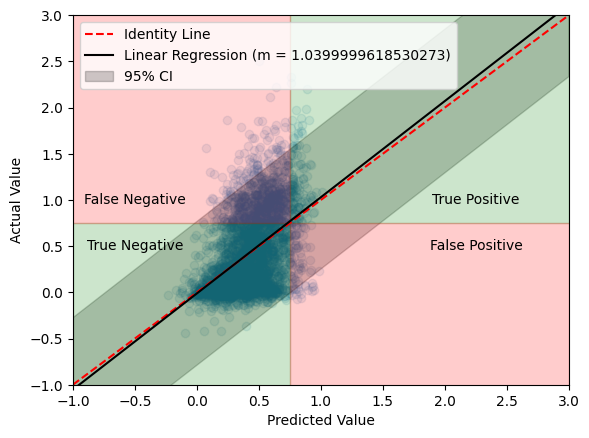

In [60]:
y_pred = best_xgb_reg.predict(X_test_scaled)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line')
plt.plot(x, y_pred_lr, color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(2.25, 1, "True Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 0.5, "True Negative", horizontalalignment = "center", verticalalignment = "center")
plt.text(2.25, 0.5, "False Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 1, "False Negative", horizontalalignment = "center", verticalalignment = "center")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

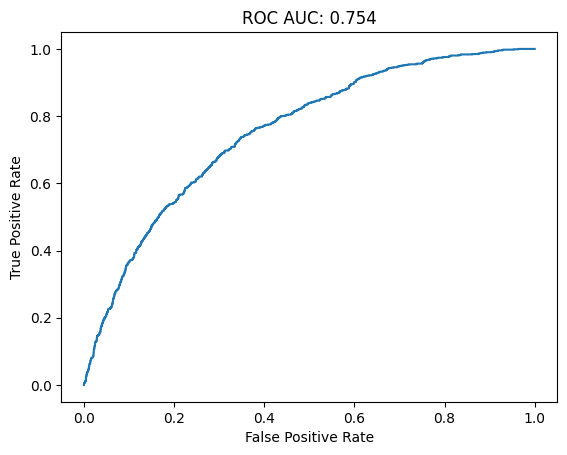

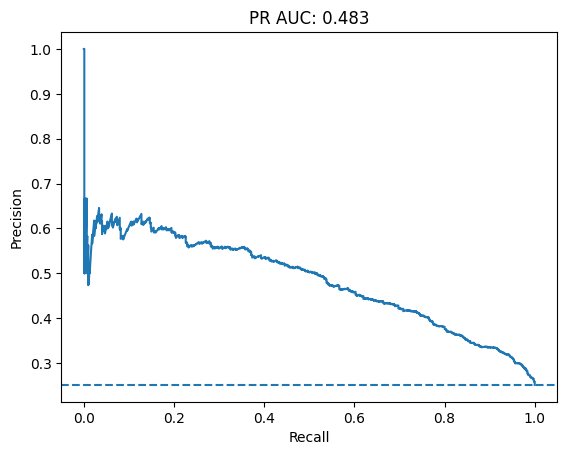

F1 score:  0.23247559893522626


In [61]:
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

# Elastic Net Linear Regression

## Fitting model

In [9]:
from sklearn.linear_model import ElasticNet

# elastic_net = ElasticNet(alpha = 1, l1_ratio = 0.5)
# elastic_net.fit(X_train_scaled, y_train)

# params = {
#     "alpha": Real(0.01, 100, prior = "log-uniform"),
#     "l1_ratio": Real(0, 1),
# }

# grid_elastic_net = BayesSearchCV(elastic_net, params, scoring = "r2", n_iter = 30, cv = 5, n_points = 2, verbose = 1)
# _ = grid_elastic_net.fit(X_train_scaled, y_train)
# best_elastic_net = grid_elastic_net.best_estimator_
# with open("models/elastic_net.pk1", "wb") as file:
#     pickle.dump(best_elastic_net, file)
    
with open("models/elastic_net.pk1", "rb") as file:
    best_elastic_net = pickle.load(file)

## Comparing model fit with test set

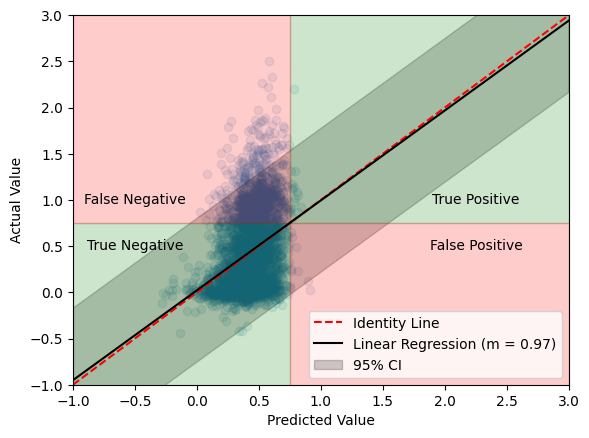

In [6]:
y_pred = best_elastic_net.predict(X_test_scaled)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line')
plt.plot(x, y_pred_lr, color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(2.25, 1, "True Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 0.5, "True Negative", horizontalalignment = "center", verticalalignment = "center")
plt.text(2.25, 0.5, "False Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 1, "False Negative", horizontalalignment = "center", verticalalignment = "center")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

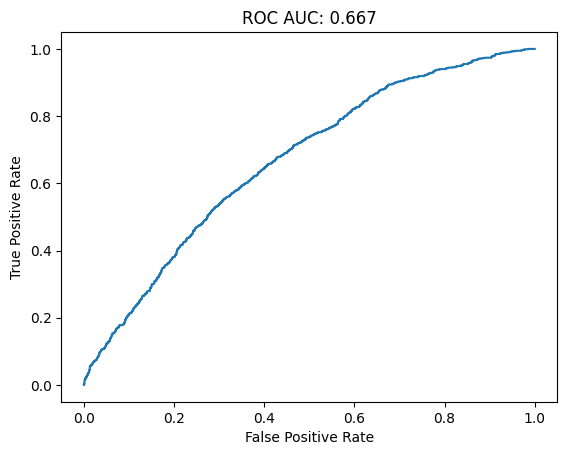

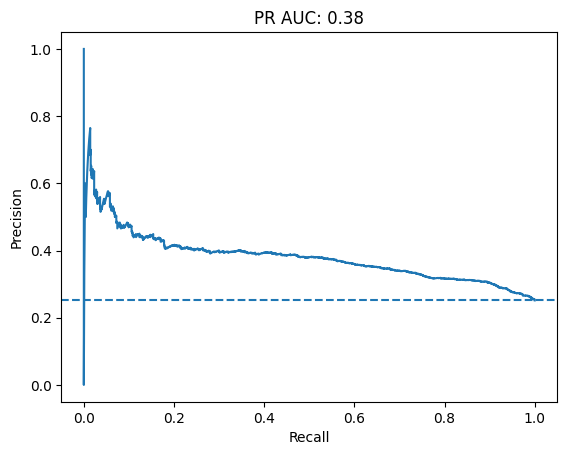

F1 score:  0.03400637619553666


In [7]:
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

# Deep Neural Network

## Constructing model

In [270]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_train_scaled_tensor = torch.tensor(X_train_scaled.values, dtype = torch.float32)
X_test_scaled_tensor = torch.tensor(X_test_scaled.values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32)

batch_size = 64
train_set = TensorDataset(X_train_scaled_tensor, y_train_tensor)
test_set = TensorDataset(X_test_scaled_tensor, y_test_tensor)

test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

class RegModelNN(nn.Module):
    def __init__(self, drop_level):
        super(RegModelNN, self).__init__()
        self.network = nn.Sequential(
            nn.LazyLinear(125),
            nn.ReLU(),
            nn.Dropout(drop_level),
            nn.LazyLinear(25),
            nn.ReLU(),
            nn.Dropout(drop_level),
            nn.LazyLinear(4),
            # nn.ReLU(),
            # nn.Dropout(drop_level),
            nn.LazyLinear(1)
        )
    
    def forward(self, x):
        return self.network(x)
    
criterion = nn.SmoothL1Loss()
model = RegModelNN(0.5)
optimizer = optim.AdamW(model.parameters(), weight_decay = 0.1, lr = 1e-3)

## Training model

In [271]:
num_epochs = 200
patience = 10
best_val_loss = float("inf")
epochs_no_improve = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):

    # put model into evaluation mode
    model.eval()
    val_loss = 0

    # determine evaluation score for model
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)

    # if the loss is greater than the best loss seen, add one to the early stopping counter
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # see if we trigger early stopping
    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

    model.train()
    running_loss = 0
    
    # training the model
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f"Epoch [{epoch + 1} / {num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}")

Epoch [1 / 200], Training Loss: 0.0886, Validation Loss: 0.0942
Epoch [2 / 200], Training Loss: 0.0846, Validation Loss: 0.0845
Epoch [3 / 200], Training Loss: 0.0823, Validation Loss: 0.0820
Epoch [4 / 200], Training Loss: 0.0810, Validation Loss: 0.0825
Epoch [5 / 200], Training Loss: 0.0798, Validation Loss: 0.0812
Epoch [6 / 200], Training Loss: 0.0781, Validation Loss: 0.0813
Epoch [7 / 200], Training Loss: 0.0768, Validation Loss: 0.0807
Epoch [8 / 200], Training Loss: 0.0755, Validation Loss: 0.0823
Epoch [9 / 200], Training Loss: 0.0746, Validation Loss: 0.0812
Epoch [10 / 200], Training Loss: 0.0728, Validation Loss: 0.0809
Epoch [11 / 200], Training Loss: 0.0720, Validation Loss: 0.0811
Epoch [12 / 200], Training Loss: 0.0710, Validation Loss: 0.0812
Epoch [13 / 200], Training Loss: 0.0707, Validation Loss: 0.0829
Epoch [14 / 200], Training Loss: 0.0694, Validation Loss: 0.0816
Epoch [15 / 200], Training Loss: 0.0685, Validation Loss: 0.0803
Epoch [16 / 200], Training Loss: 0

## Comparing model fit with test set

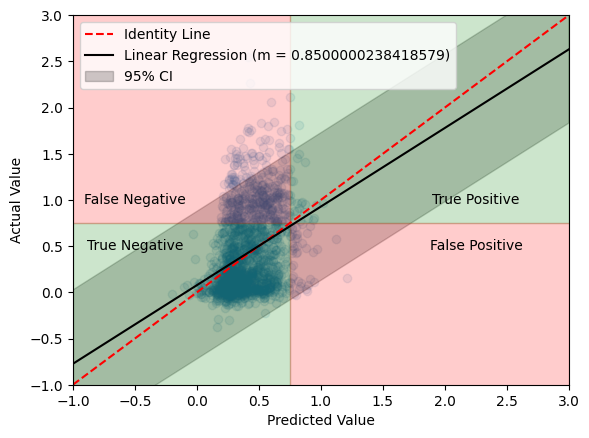

In [272]:
y_pred = model(X_test_scaled_tensor).detach().numpy()

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line')
plt.plot(x, y_pred_lr, color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(2.25, 1, "True Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 0.5, "True Negative", horizontalalignment = "center", verticalalignment = "center")
plt.text(2.25, 0.5, "False Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 1, "False Negative", horizontalalignment = "center", verticalalignment = "center")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

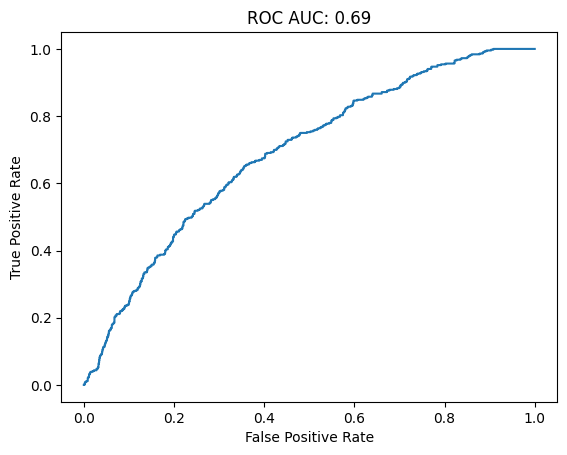

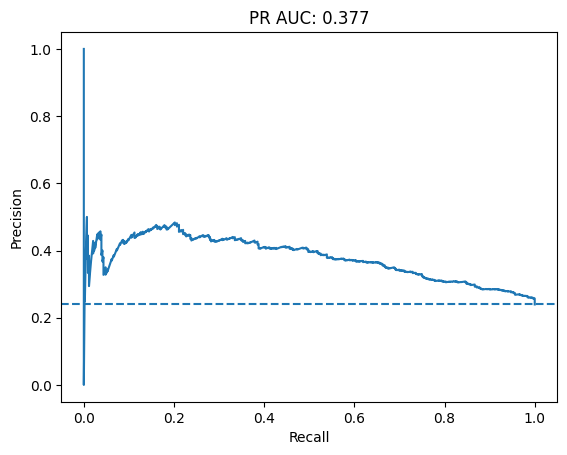

F1 score:  0.09126984126984126


In [273]:
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

# Convolutional Neural Network

## Constructing model

In [363]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

def encode_seq(seq):
    mapping = {"A": [1, 0, 0, 0],
               "T": [0, 1, 0, 0],
               "C": [0, 0, 1, 0],
               "G": [0, 0, 0, 1]}
    return [mapping[b] for b in seq.upper()]

CNN_df = df.loc[:, ["sequence", "score"]]

stan = StandardScaler()
CNN_df["encoding"] = CNN_df["sequence"].apply(encode_seq)

# pad all sequences based on the longest value and store in tensor
padded_tensor = pad_sequence([torch.tensor(seq, dtype = torch.float32) for seq in CNN_df["encoding"].tolist()], batch_first = True, padding_value = 0)

# defining training and testing set
X_train, X_test, seq_train, seq_test, y_train, y_test = train_test_split(X, padded_tensor, y, test_size = 0.2, random_state = 0)

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[stan_cols] = stan.fit_transform(X_train_scaled[stan_cols])
X_train_scaled[minmax_cols] = minmax.fit_transform(X_train_scaled[minmax_cols])
X_test_scaled[stan_cols] = stan.transform(X_test_scaled[stan_cols])
X_test_scaled[minmax_cols] = minmax.transform(X_test_scaled[minmax_cols])

train_dataset = TensorDataset(torch.tensor(X_train_scaled.values, dtype = torch.float32), seq_train, torch.tensor(y_train.values, dtype = torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_scaled.values, dtype = torch.float32), seq_test, torch.tensor(y_test.values, dtype = torch.float32))

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

class CNNReg(nn.Module):
    def __init__(self):
        super(CNNReg, self).__init__()
        self.seq_cnn = nn.Sequential(
            nn.LazyConv1d(out_channels = 32, kernel_size = 3, padding = 1),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2),
            nn.Dropout(0.25),
            nn.LazyConv1d(out_channels = 64, kernel_size = 3, padding = 1),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2),
            nn.Dropout(0.25),
            nn.Flatten(),
        )
        
        self.dist_lin = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(64)
        )
        
        self.final_lin = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(1)
        )
        
    def forward(self, x, additional_features):
        x = self.seq_cnn(x)
        additional_features = self.dist_lin(additional_features)
        x = torch.cat((x, additional_features.squeeze(1)), dim = 1)
        x = self.final_lin(x)
        return x
    
model = CNNReg()
# criterion = nn.SmoothL1Loss(beta = 0.1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

## Training model

In [364]:
n_epochs = 100
patience = 10
best_val_loss = float("inf")
patient_counter = 0

for epoch in range(n_epochs):
    model.train()
    running_loss = 0
    breakpoint()
    for features, seq, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(seq, features)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, seq, labels in test_loader:
            outputs = model(seq, features)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
            
    print(f"Epoch [{epoch+1}/{n_epochs}], Training Loss: {round(avg_train_loss, 5)}, Validation Loss: {round(avg_val_loss , 5)}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
torch.save(model.state_dict(), "models/CNN.pth")

Epoch [1/100], Training Loss: 0.32802, Validation Loss: 0.30781
Epoch [2/100], Training Loss: 0.31487, Validation Loss: 0.30285
Epoch [3/100], Training Loss: 0.30672, Validation Loss: 0.29693
Epoch [4/100], Training Loss: 0.30029, Validation Loss: 0.28609
Epoch [5/100], Training Loss: 0.2965, Validation Loss: 0.28641
Epoch [6/100], Training Loss: 0.29397, Validation Loss: 0.28119
Epoch [7/100], Training Loss: 0.2895, Validation Loss: 0.27866
Epoch [8/100], Training Loss: 0.28674, Validation Loss: 0.27861
Epoch [9/100], Training Loss: 0.2827, Validation Loss: 0.27617
Epoch [10/100], Training Loss: 0.28067, Validation Loss: 0.27254
Epoch [11/100], Training Loss: 0.27924, Validation Loss: 0.27607
Epoch [12/100], Training Loss: 0.27666, Validation Loss: 0.27078
Epoch [13/100], Training Loss: 0.2726, Validation Loss: 0.27132
Epoch [14/100], Training Loss: 0.2699, Validation Loss: 0.27288
Epoch [15/100], Training Loss: 0.26976, Validation Loss: 0.2702
Epoch [16/100], Training Loss: 0.26557, 

## Comparing model fit with test set

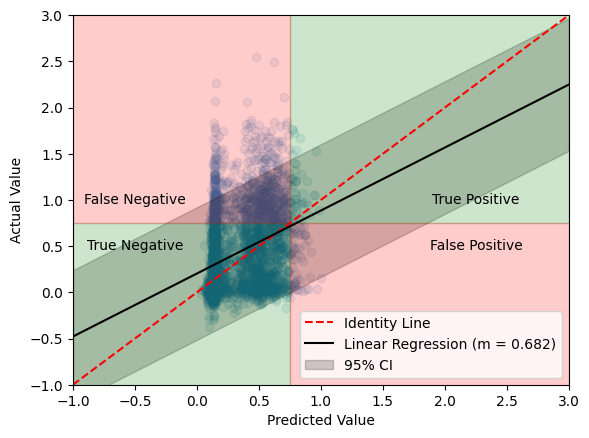

In [374]:
model.load_state_dict(torch.load("models/CNN.pth"))

y_pred = model(seq_test, torch.tensor(X_test_scaled.values, dtype = torch.float32)).detach().numpy()

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis

xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line')
plt.plot(x, y_pred_lr, color = "black", label = f"Linear Regression (m = {slope:.3f})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(2.25, 1, "True Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 0.5, "True Negative", horizontalalignment = "center", verticalalignment = "center")
plt.text(2.25, 0.5, "False Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 1, "False Negative", horizontalalignment = "center", verticalalignment = "center")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

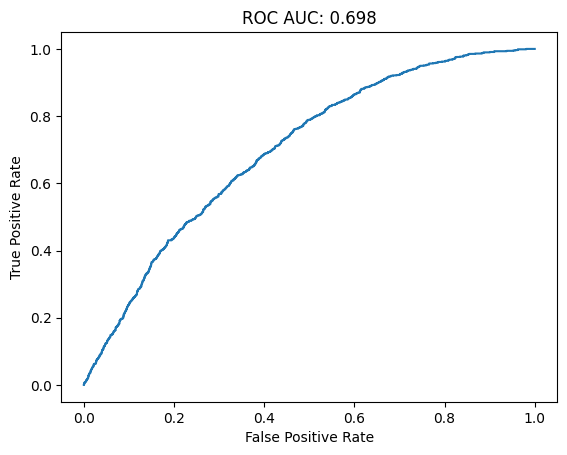

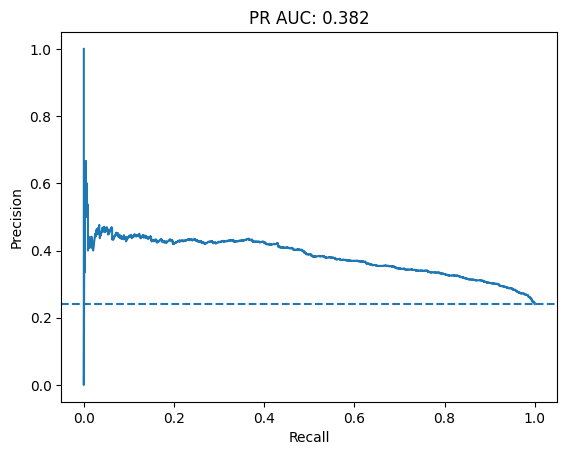

F1 score:  0.09601634320735444


In [376]:
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)